# Task #1 

A template code for training an RBM on H$_2$ data for $r = 1.2$ is shown here. Modify this!

Imports and loading in data:

In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from RBM_helper import RBM
import H2_energy_calculator
import typing
import collections

# training_data = torch.from_numpy(np.loadtxt("H2_data/R_1.2_samples.txt"))
training_data = torch.from_numpy(np.loadtxt("H2_data/R_1.2_samples.txt"))
coeff = np.loadtxt("H2_data/H2_coefficients.txt")[20,:]

true_energy = H2_energy_calculator.energy_from_freq(training_data, coeff)
print("H2 energy for r = 1.2: ",true_energy)

H2 energy for r = 1.2:  -1.0642022250418146


Define the RBM:

In [2]:
n_vis = 2
n_hin = 10

rbm = RBM(n_vis, n_hin)

Train the RBM:

In [3]:
def train_RBM( training_data): 
    '''
        Train a restricted Boltzmann Machine 
        
        Args:
            training_data: The training array
        Returns:
            Array: An N_draw array containing the energies  
    '''
    
    epochs = 500 # number of training steps
    num_samples = 1000 # number of samples to generate from the RBM to calculate the H2 energy
    N_draws = 1000 # For quantifying the variance of the final model

    true_energy = H2_energy_calculator.energy_from_freq(training_data, coeff)
    #print("True energy: ",true_energy)

    for e in range(1, epochs+1):
        # do one epoch of training
        rbm.train(training_data)   

    # Draw several samples for the purpose of uncertainty quantification of the final results
    
    E_samples = np.zeros(N_draws)
    
    for k in range(0,N_draws):
        init_state = torch.zeros(num_samples, n_vis)
        RBM_samples = rbm.draw_samples(15, init_state)
        energies = H2_energy_calculator.energy(RBM_samples, coeff, rbm.wavefunction)
        E_samples[k] = energies.item()

    return E_samples,true_energy


def confidence_interval(x):
    '''
    
        Compute the 68% and 96% confidence inteval of a data set
        
        Args:
            x: numpy array
        Returns:
            Tuple: array1,array2
            
            where array1 and array2 are each numpy arrays of length=3
            array1 = [lower_68%_bound, median , upper_68%_bound]
            array2 = [lower_96%_bound, median , upper_96%_bound]
    '''
    
    x_68 = np.percentile(x, [16,50,84])
    x_96 = np.percentile(x, [2,50,98])
    
    return x_68,x_96

In [4]:
# Sort the available radii first

radii = []

for entry in os.scandir('H2_data/'):
    if (entry.path.endswith("samples.txt")):
        radius =  float(entry.name.split("_")[1])
        radii.append(radius)

radii = np.array(radii)
radii.sort()

In [5]:
r_subset = []
E_true_r = []
E_rbm_r_med = []
E_rbm_r_low_68 = []
E_rbm_r_high_68 = []
E_rbm_r_low_96 = []
E_rbm_r_high_96 = []


for k in range(0,len(radii),1):
    rk = radii[k]
    
    r_subset.append(rk)
    
    file_name = 'H2_data/R_'+str(rk)+'_samples.txt'
    training_data = torch.from_numpy(np.loadtxt(file_name))
    E_rbm_samples, E_true = train_RBM(training_data)
    E_68,E_96 = confidence_interval(E_rbm_samples)
                                     
    print('r={} [], E(rbm)={} [], E(true)={} []'.format(rk,E_68[1],E_true))
    
    E_rbm_r_high_68.append(E_68[2])
    E_rbm_r_high_96.append(E_96[2])
                
    E_rbm_r_low_68.append(E_68[0])
    E_rbm_r_low_96.append(E_96[0])
    
    E_rbm_r_med.append(E_68[1])
    E_true_r.append(E_true)

r=0.2 [], E(rbm)=-1.0099469536502927 [], E(true)=-1.0272612255781348 []
r=0.25 [], E(rbm)=-1.0090880053162754 [], E(true)=-1.0285713264808696 []
r=0.3 [], E(rbm)=-1.0094403887094114 [], E(true)=-1.0289787152870253 []
r=0.35 [], E(rbm)=-1.0094768213946503 [], E(true)=-1.0324782127249015 []
r=0.4 [], E(rbm)=-1.0145785648784984 [], E(true)=-1.0339439695134862 []
r=0.45 [], E(rbm)=-1.0275617487564992 [], E(true)=-1.0362617443402724 []
r=0.5 [], E(rbm)=-1.0898872817929448 [], E(true)=-1.0380608769339534 []
r=0.55 [], E(rbm)=-1.191665023231987 [], E(true)=-1.0392850239621994 []
r=0.6 [], E(rbm)=-1.2716468000201409 [], E(true)=-1.0430990090273842 []
r=0.65 [], E(rbm)=-1.30491580957406 [], E(true)=-1.0452519125171207 []
r=0.7 [], E(rbm)=-1.3404515498211782 [], E(true)=-1.046658951711928 []
r=0.75 [], E(rbm)=-1.3343166618958904 [], E(true)=-1.0494348817130146 []
r=0.8 [], E(rbm)=-1.310197812085183 [], E(true)=-1.0531258395865126 []
r=0.85 [], E(rbm)=-1.304897340470591 [], E(true)=-1.05379477360

In [22]:
# Save all of the data as a pandas dataframe and export 
data = {'r': r_subset, 
        'E_rbm_r_low_96': E_rbm_r_low_96,
        'E_rbm_r_low_68': E_rbm_r_low_68,
        'E_rbm_r_high_68': E_rbm_r_high_68,
        'E_rbm_r_high_96': E_rbm_r_high_96,
        'E_rbm_r_median': E_rbm_r_med}

df = pd.DataFrame(data=data)

df.head()
df.to_csv('E_RBM_H2_molecule.csv', index=False)

# Plot the potential energy surface extracted from the RBM as a function of the distance R

Having carried out several calculations of the RBM energy by varying th radius $R$, we now plot the resulting curve. We also include the 68% and 96% confidence intervals.  

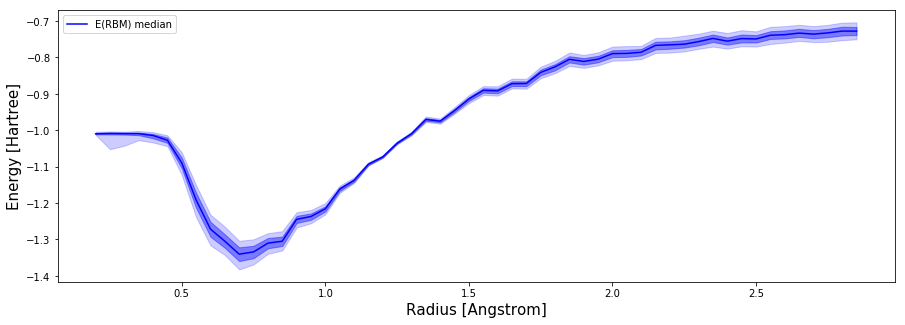

In [24]:
plt.figure(figsize=(15,5))
plt.plot(r_subset,E_rbm_r_med,label='E(RBM) median',color='blue')
plt.fill_between(r_subset,E_rbm_r_low_68, E_rbm_r_high_68,color='blue',alpha='0.4',edgecolor='b') 
plt.fill_between(r_subset,E_rbm_r_low_96, E_rbm_r_high_96,color='blue',alpha='0.2',edgecolor='b') 
plt.ylabel('Energy [Hartree]',size=15)
plt.xlabel('Radius [Angstrom]',size=15)
plt.legend()
plt.show()

Finally we also plot the exact energy as a function of radius. We see that there is a minimum in the potential energy at approximately $R=0.7$ Angstrom, which represents the size of the $H_2$ molecule. In a subsequent notebook, we will analyse this surface to obtain the expcted minimum of this surface.

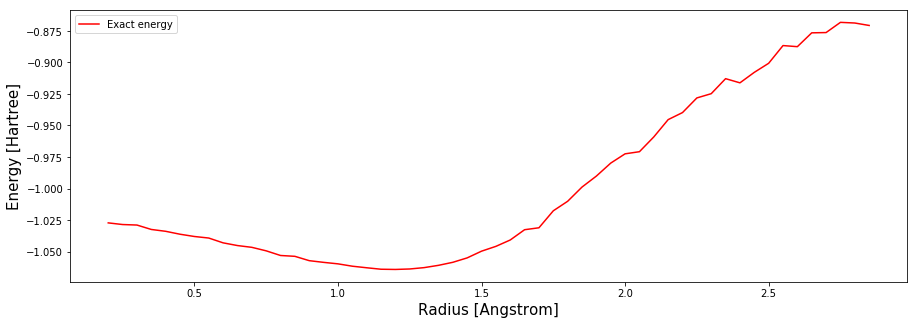

In [25]:
plt.figure(figsize=(15,5))
plt.plot(r_subset, np.array(E_true_r),label='Exact energy',color='red')
plt.ylabel('Energy [Hartree]',size=15)
plt.xlabel('Radius [Angstrom]',size=15)
plt.legend()
plt.show()